In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


In [19]:
# Define image size and batch size
IMG_SHAPE = (64, 64, 3)  # Change as needed
BATCH_SIZE = 32

# Set dataset paths
train_path = "/kaggle/input/dataset/modified-4000"

# Data Generator
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode="input"  # Since it's an autoencoder
)


Found 4000 images belonging to 2 classes.


In [5]:
latent_dim = 128  # Change as needed

def build_encoder():
    inputs = keras.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(32, (3,3), activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Latent space
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    encoder = keras.Model(inputs, [z_mean, z_log_var], name="encoder")
    return encoder

encoder = build_encoder()
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      4,194,560 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 128)            │         32,896 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,279,744 (16.33 MB)

 Trainable params: 4,279,744 (16.33 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [7]:
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)
    x = layers.Conv2DTranspose(64, (3,3), activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, (3,3), activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv2DTranspose(3, (3,3), activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, outputs, name="decoder")
    return decoder

decoder = build_decoder()
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16384)               │       2,113,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,169,795 (8.28 MB)

 Trainable params: 2,169,795 (8.28 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed

vae = VAE(encoder, decoder)


In [27]:
def vae_loss(inputs, outputs):
    mse_loss = tf.keras.losses.MeanSquaredError()(inputs, outputs)  # Fix here
    mse_loss *= IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]
    return tf.reduce_mean(mse_loss)

vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=vae_loss)


## EPOCHS = 200  # Adjust as needed

history = vae.fit(train_generator, epochs=EPOCHS)

# Save model
vae.save("vae_model.h5")


In [26]:
import os
import numpy as np
from PIL import Image  # ✅ Import Image module

num_samples = 1000  # Generate 500 synthetic images
latent_samples = np.random.normal(size=(num_samples, latent_dim))
generated_images = decoder.predict(latent_samples)

# Convert images to 0-255 scale
generated_images = (generated_images * 255).astype(np.uint8)

# Save images
os.makedirs("generated_images", exist_ok=True)
for i in range(num_samples):
    img = Image.fromarray(generated_images[i])  # ✅ Now Image is recognized
    img.save(f"generated_images/image_{i}.png")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [19]:
from zipfile import ZipFile  # ✅ Import ZipFile

zip_filename = "generated_images.zip"

with ZipFile(zip_filename, 'w') as zipf:
    for i in range(num_samples):
        zipf.write(f"generated_images/image_{i}.png")

print("Images saved and zipped successfully!")


Images saved and zipped successfully!


In [25]:
import shutil
shutil.move("generated_images.zip", "/kaggle/working/generated_images.zip")


'/kaggle/working/generated_images.zip'

In [24]:
import os

synthetic_folder = "/kaggle/working/generated_images"

if os.path.exists(synthetic_folder):
    print("✅ Folder exists:", synthetic_folder)
    print("Total images:", len(os.listdir(synthetic_folder)))
else:
    print("❌ Folder not found:", synthetic_folder)


✅ Folder exists: /kaggle/working/generated_images
Total images: 0


In [21]:
import shutil

# Define source and destination paths
source_folder = "/kaggle/working/generated_images"
destination_folder = "/kaggle/working/dataset/modified-4000/train/cancer1"

# Ensure the destination exists
os.makedirs(destination_folder, exist_ok=True)

# Move images
for img_file in os.listdir(source_folder):
    src = os.path.join(source_folder, img_file)
    dst = os.path.join(destination_folder, img_file)
    
    if os.path.exists(src):  # Move only if file exists
        shutil.move(src, dst)
    else:
        print(f"❌ Skipping {src}, file not found!")

print(f"✅ Merging completed! Total images in {destination_folder}: {len(os.listdir(destination_folder))}")


✅ Merging completed! Total images in /kaggle/working/dataset/modified-4000/train/cancer1: 1000


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [7]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dir = "/kaggle/input/finalvae/Final/Final/train"
test_dir = "/kaggle/input/finalvae/Final/Final/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train Images: {len(train_dataset)} (Expected: 4200)")
print(f"Test Images: {len(test_dataset)} (Expected: 800)")


Train Images: 3324 (Expected: 4200)
Test Images: 923 (Expected: 800)


In [8]:
# Cell 3: Define Vision Transformer model
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=128):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Conv2d(1, emb_size, kernel_size=16, stride=16)

    def forward(self, x):
        x = self.projection(x).flatten(2).transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_size, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(emb_size, heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(nn.Linear(emb_size, emb_size), nn.ReLU())
        self.dropout = nn.Dropout(dropout)  # ✅ Added dropout layer

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))  # ✅ Apply dropout
        ff_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_output))  # ✅ Apply dropout
        return x

class VisionTransformer(nn.Module):
    def __init__(self, num_classes, emb_size=128, num_heads=4, num_layers=6):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(emb_size)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(emb_size, num_heads) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = x.mean(dim=1, keepdim=True).squeeze(1)  # ✅ Prevent shape mismatches
        x = self.fc(x)
        return x


In [9]:
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Define scheduler before training
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 75
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    scheduler.step()  # ✅ This will now work!

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/75], Loss: 0.7365
Epoch [2/75], Loss: 0.6967
Epoch [3/75], Loss: 0.6999
Epoch [4/75], Loss: 0.6999
Epoch [5/75], Loss: 0.6962
Epoch [6/75], Loss: 0.6983
Epoch [7/75], Loss: 0.6929
Epoch [8/75], Loss: 0.6936
Epoch [9/75], Loss: 0.6923
Epoch [10/75], Loss: 0.6928
Epoch [11/75], Loss: 0.6901
Epoch [12/75], Loss: 0.6902
Epoch [13/75], Loss: 0.6915
Epoch [14/75], Loss: 0.6896
Epoch [15/75], Loss: 0.6907
Epoch [16/75], Loss: 0.6902
Epoch [17/75], Loss: 0.6903
Epoch [18/75], Loss: 0.6891
Epoch [19/75], Loss: 0.6901
Epoch [20/75], Loss: 0.6898
Epoch [21/75], Loss: 0.6892
Epoch [22/75], Loss: 0.6887
Epoch [23/75], Loss: 0.6890
Epoch [24/75], Loss: 0.6902
Epoch [25/75], Loss: 0.6885
Epoch [26/75], Loss: 0.6892
Epoch [27/75], Loss: 0.6889
Epoch [28/75], Loss: 0.6896
Epoch [29/75], Loss: 0.6893
Epoch [30/75], Loss: 0.6885
Epoch [31/75], Loss: 0.6881
Epoch [32/75], Loss: 0.6886
Epoch [33/75], Loss: 0.6885
Epoch [34/75], Loss: 0.6878
Epoch [35/75], Loss: 0.6881
Epoch [36/75], Loss: 0.6881
E

In [7]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')



Test Accuracy: 56.45%


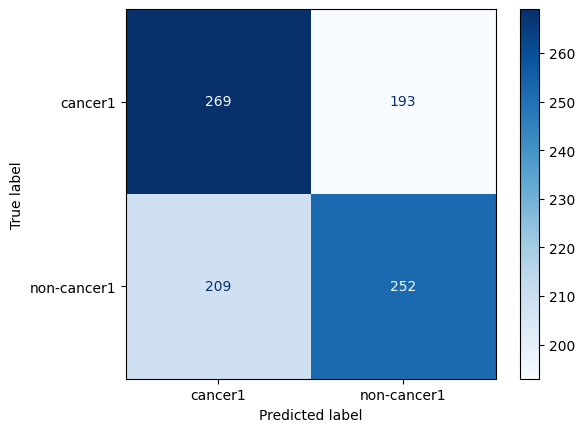

In [8]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.show()


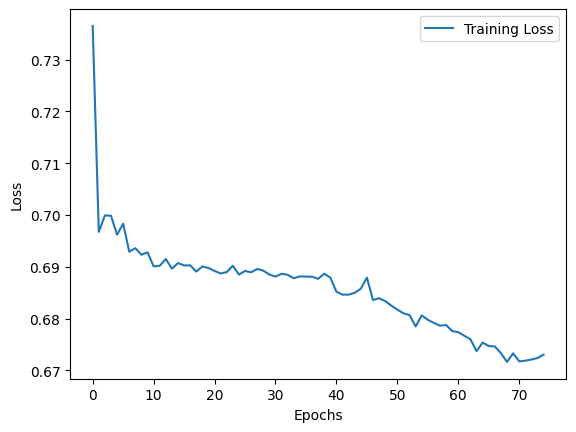

In [9]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
print(f"Final loss function: {criterion}")


Final loss function: CrossEntropyLoss()


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
)


In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dir = "/kaggle/input/finalvae/Final/Final/train"
test_dir = "/kaggle/input/finalvae/Final/Final/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train Images: {len(train_dataset)} (Expected: 4200)")
print(f"Test Images: {len(test_dataset)} (Expected: 800)")


Train Images: 3324 (Expected: 4200)
Test Images: 923 (Expected: 800)


In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=128):
        super(PatchEmbedding, self).__init__()
        self.projection = nn.Conv2d(1, emb_size, kernel_size=16, stride=16)

    def forward(self, x):
        x = self.projection(x).flatten(2).transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_size, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(emb_size, heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ffn = nn.Sequential(nn.Linear(emb_size, emb_size), nn.ReLU())
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, num_classes, emb_size=128, num_heads=4, num_layers=6):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(emb_size)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(emb_size, num_heads) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        for block in self.transformer_blocks:
            x = block(x)
        x = x.mean(dim=1).squeeze(1)
        x = self.fc(x)
        return x


In [13]:
num_classes = len(train_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    scheduler.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/100], Loss: 0.7685
Epoch [2/100], Loss: 0.6974
Epoch [3/100], Loss: 0.6970
Epoch [4/100], Loss: 0.6977
Epoch [5/100], Loss: 0.6956
Epoch [6/100], Loss: 0.6946
Epoch [7/100], Loss: 0.6909
Epoch [8/100], Loss: 0.6926
Epoch [9/100], Loss: 0.6941
Epoch [10/100], Loss: 0.6917
Epoch [11/100], Loss: 0.6901
Epoch [12/100], Loss: 0.6904
Epoch [14/100], Loss: 0.6926
Epoch [15/100], Loss: 0.6899
Epoch [16/100], Loss: 0.6926
Epoch [17/100], Loss: 0.6910
Epoch [18/100], Loss: 0.6879
Epoch [19/100], Loss: 0.6924
Epoch [20/100], Loss: 0.6907
Epoch [21/100], Loss: 0.6890
Epoch [22/100], Loss: 0.6892
Epoch [23/100], Loss: 0.6884
Epoch [24/100], Loss: 0.6886
Epoch [25/100], Loss: 0.6890
Epoch [26/100], Loss: 0.6890
Epoch [27/100], Loss: 0.6889
Epoch [28/100], Loss: 0.6889
Epoch [29/100], Loss: 0.6893
Epoch [30/100], Loss: 0.6880
Epoch [31/100], Loss: 0.6869
Epoch [32/100], Loss: 0.6876
Epoch [33/100], Loss: 0.6871
Epoch [34/100], Loss: 0.6881
Epoch [54/100], Loss: 0.6739
Epoch [55/100], Loss: 0

In [14]:
model.eval()
all_labels = []
all_preds = []
 
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)

# Results
print("\n📊 Evaluation Metrics:")
print(f"✔ Accuracy:  {accuracy * 100:.2f}%")
print(f"✔ Precision: {precision:.4f}")
print(f"✔ Recall:    {recall:.4f}")
print(f"✔ F1 Score:  {f1:.4f}")
print(f"✔ MSE:       {mse:.4f}")
print(f"✔ RMSE:      {rmse:.4f}")



📊 Evaluation Metrics:
✔ Accuracy:  54.39%
✔ Precision: 0.5441
✔ Recall:    0.5438
✔ F1 Score:  0.5433
✔ MSE:       0.4561
✔ RMSE:      0.6754


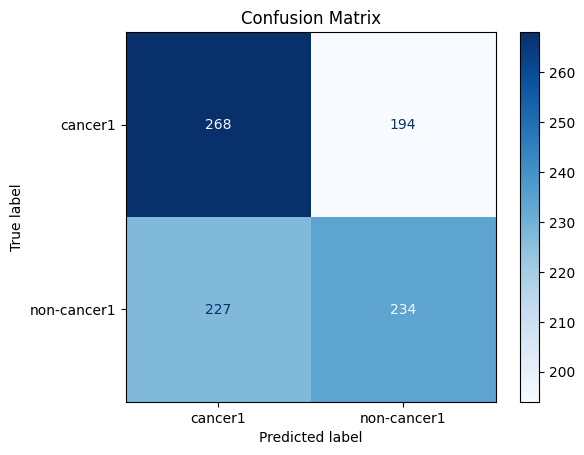

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [16]:
print("📋 Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


📋 Classification Report:

              precision    recall  f1-score   support

     cancer1       0.54      0.58      0.56       462
 non-cancer1       0.55      0.51      0.53       461

    accuracy                           0.54       923
   macro avg       0.54      0.54      0.54       923
weighted avg       0.54      0.54      0.54       923



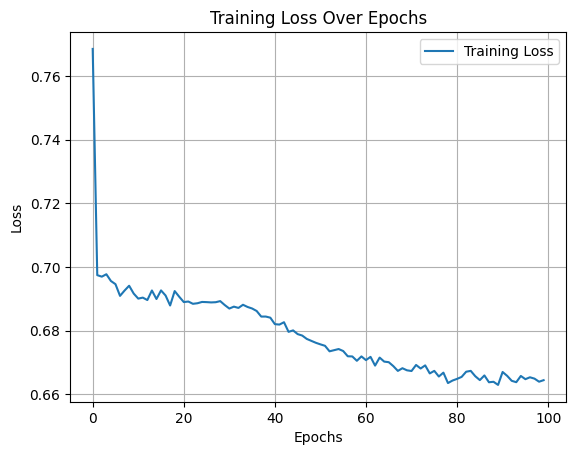

In [17]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


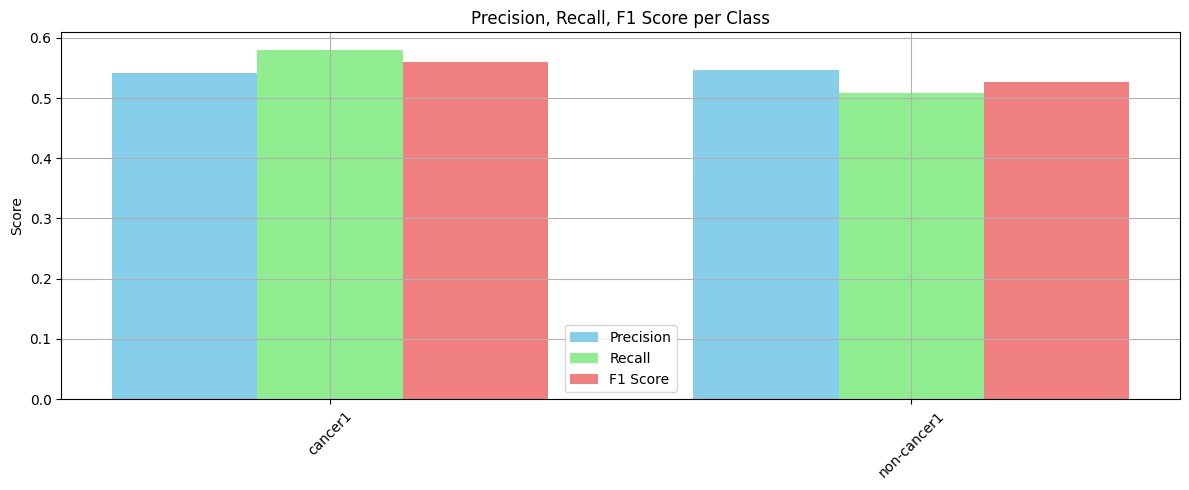

In [18]:
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    all_labels, all_preds, average=None
)

classes = train_dataset.classes
x = np.arange(len(classes))

plt.figure(figsize=(12, 5))
plt.bar(x - 0.25, precision_per_class, width=0.25, label='Precision', color='skyblue')
plt.bar(x, recall_per_class, width=0.25, label='Recall', color='lightgreen')
plt.bar(x + 0.25, f1_per_class, width=0.25, label='F1 Score', color='lightcoral')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score per Class')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
